In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set()
import random
import os

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000000)
pd.options.mode.chained_assignment = None 

In [3]:
csvs = sorted([i for i in os.listdir('data/') if i.startswith('results_df')])

In [4]:
# get all of the csvs that have written out from the previous process
csvs = sorted([i for i in os.listdir('data') if i.startswith('results_df')])
results_df = pd.DataFrame()
for csv in csvs:
    t = pd.read_csv('data/' + csv)
    results_df = pd.concat([results_df, t], axis=0)

results_df = results_df.drop(columns='Unnamed: 0')
clean_df = pd.read_csv('data/play_by_play_2016.csv').drop(columns='Unnamed: 0')

In [5]:
remove_cols = ['Fielders Choice', 'Sacrifice Fly', 'Fielder\'s Choice-Adv-2nd', 
               'Sacrifice Bunt', 'Reached on error-Adv-3rd', 'Reached on error-Adv-2nd', 
               'Catcher Interference', 'Sacrifice Bunt-Adv-2nd', 'Sacrifice Bunt', 
               'Dirt Ball', 'Sacrifice Fly-Adv-2nd', 'Fielders Choice - Out at 2nd', 
               'Sacrifice Fly-Adv-1st', 'Sacrifice Bunt-Adv-1st', 'Reached On Error - Out at 2nd', 
               'Balk', 'Reached on error', 'Hit by pitch']

high_level_groupings = {
    'ball' : ['Ball', 'Intentional Ball', 'Pitch Out'], 
    
    'strike' : 
        ['Strike Looking', 'Strike Swinging', ' Strike Swinging - Out at Home', 
         'Strike-swinging-Adv-1st', 'Strike-looking-Adv-1st', 'Single - Out at 3rd', 
         'Strike Looking - Out at 1st'], 
    
    'contact_in_play_out' : 
        ['Pop Out', 'Ground Out', 'Fly Out', 'Line Out'], 
    
    'contact_in_on_base' : 
        ['Homerun', 'Single', 'Double', 'Single - Out at 2nd', 'Triple', 'Single-Adv-2nd', 
         'Double-Adv-3rd', 'Double Out at 3rd', 'Single-Adv-Home', 'Single-Adv-3rd', 'Double-Adv-Home', 
         'Triple-Adv-Home', 'Triple - Out at Home', 'Double-Adv-Home'], 
    
    'contact_foul' : ['Foul Ball', 'Foul Tip', ]
}

# remove any bat_id with 'rare' events (~10% of at-bats)
remove_ids = clean_df.loc[clean_df['outcomeDescription'].isin(remove_cols)]['bat_id'].unique()
clean_df = clean_df.loc[~clean_df['bat_id'].isin(remove_ids)]

# theres currently no assignment for a walk; create new column for outcome called walk
clean_df['walk_flag'] = np.where(
    ((clean_df['startingBalls'] == 3) & 
     (clean_df['outcomeDescription'].isin(high_level_groupings['ball']))), 1, 0
)

# do the same for strikes
clean_df['strikeout_flag'] = np.where(
    ((clean_df['startingStrikes'] == 2) & 
    (clean_df['outcomeDescription'].isin(high_level_groupings['strike']))), 1, 0
)

# put the previous ids in the data
clean_df['prev_state_id'] = (
    clean_df.sort_values(by=['bat_id', 'event_num'], ascending=True)
      .groupby('bat_id')['outcomeId']
      .shift(1)
      .fillna('bFP')
)

clean_df['prev_state_desc'] = (
    clean_df.sort_values(by=['bat_id', 'event_num'], ascending=True)
      .groupby('bat_id')['outcomeDescription']
      .shift(1)
      .fillna('First Pitch')
)

# assign based on the dictonary above
clean_df['assigned_outcome'] = ''
clean_df['prev_assigned_outcome'] = ''
for outcome, grouping in high_level_groupings.items(): 
    clean_df['assigned_outcome'] = np.where(
        clean_df['walk_flag'] == 1, 'walk', 
            np.where(clean_df['strikeout_flag'] == 1, 'strikeout',
                np.where(
                    clean_df['outcomeDescription'].isin(grouping), outcome, clean_df['assigned_outcome']
                )
            )          
        )
    
    # has the previous outcomes as the same grouping (except itis imporssible to get a walk here)
    clean_df['prev_assigned_outcome'] = np.where(
            clean_df['prev_state_desc'] == 'First Pitch', 'first_pitch',
            np.where(
                clean_df['prev_state_desc'].isin(grouping), outcome, clean_df['prev_assigned_outcome']
            )
    )

### Check to see how many I got 'right'

In [6]:
# create a column for predicted outcome
prob_cols = [
    'ball', 'contact_foul', 'contact_in_on_base', 
    'contact_in_play_out', 'strike', 'strikeout', 'walk'
]

results_df['max_prob'] = results_df[prob_cols].max(axis=1)
results_df['predicted_result'] = ''

for prob_col in prob_cols: 
    results_df['predicted_result'] = np.where(
        results_df[prob_col] ==  results_df['max_prob'], 
        prob_col, results_df['predicted_result'] 
        
    )
    
# create a marker when I got the 'right' outcome
results_df['correct_flag'] = np.where(
        results_df['predicted_result'] ==  results_df['actual_outcome'], 1, 0
)

In [7]:
# look at accuracy 
results_df['correct_flag'].sum() / results_df['correct_flag'].count()

0.4082994653271862

In [8]:
# if I randomly assign based on percentiles from real data 
# how well do I do 
# not the greatest way - because a 'good' model should almost never predict basehits
pct_df = clean_df.groupby('assigned_outcome').agg({'pitch_id' : 'count'}).reset_index()
pct_df['pct'] = pct_df['pitch_id'] / pct_df['pitch_id'].sum()
pct_df = pct_df[['assigned_outcome', 'pct']]
outcomes, chance = pct_df['assigned_outcome'].tolist(), pct_df['pct'].tolist()

chance_df = results_df
chance_df['random_outcome'] = np.random.choice(a=outcomes, p=chance, size=len(results_df))

chance_df['random_correct_flag'] = np.where(
    results_df['predicted_result'] ==  results_df['random_outcome'], 1, 0
)

In [9]:
chance_df['random_correct_flag'].sum() / chance_df['random_outcome'].count()

0.28105084213159737

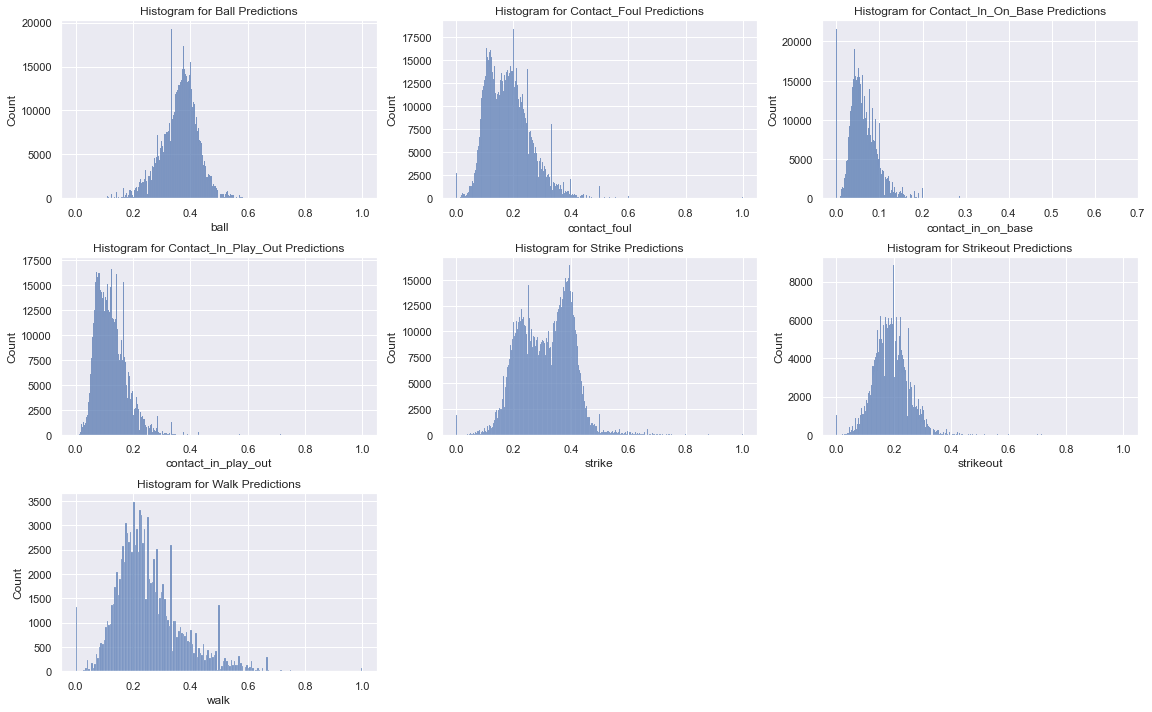

In [10]:
# plot the distrubution for all of the columns that you kept
plt.figure(figsize=(16, 10))

for index, col in enumerate(prob_cols, start=1): 
    plt.subplot(3, 3, index)
    sns.histplot(results_df[col]).set(title=f'Histogram for {col.title()} Predictions')

plt.tight_layout()
plt.show()

### Look at these distrubutions by the current count

In [11]:
count_df = clean_df[['pitch_id', 'startingBalls', 'startingStrikes']]
# now look at the various histograms by the count of the play
ball_stike_df = results_df.merge(right=count_df, on=['pitch_id'], how='inner')

In [12]:
# create total columns for balls and strikes
ball_stike_df['total_ball_pct'] = np.where(
    ball_stike_df['walk'].isnull(), ball_stike_df['ball'], ball_stike_df['walk']
)

ball_stike_df['total_strike_pct'] = np.where(
    ball_stike_df['strikeout'].isnull(), ball_stike_df['strike'], ball_stike_df['strikeout']
)

In [13]:
def compute_count_dists(event_type): 
    bs_combos = [(0, 0), (1, 0), (2, 0), (3,0), (1, 1), (2, 1), (3,1), (3, 2), (1, 2), (2, 2)]
    plt.figure(figsize=(16, 10))
    for index, bs_combo in enumerate(bs_combos, start=1): 
        ball_stike_df_current = ball_stike_df.loc[
            ((ball_stike_df['startingBalls'] == bs_combo[0]) & 
             (ball_stike_df['startingStrikes'] == bs_combo[1]))
        ]

        plt.subplot(4, 3, index)

        sns.histplot(ball_stike_df_current[event_type], kde=True)\
           .set(title=f'Histogram for {col.title()} Predictions')

        plt.xlim(0, 1)
        plt.xticks(np.arange(0, 1, .1))
        plt.title(f'Histogram for {bs_combo}')
        
    plt.suptitle(f'{event_type} by Pitch Count', fontsize=14)
    plt.tight_layout()
    plt.show(); 
    print('-' * 100)

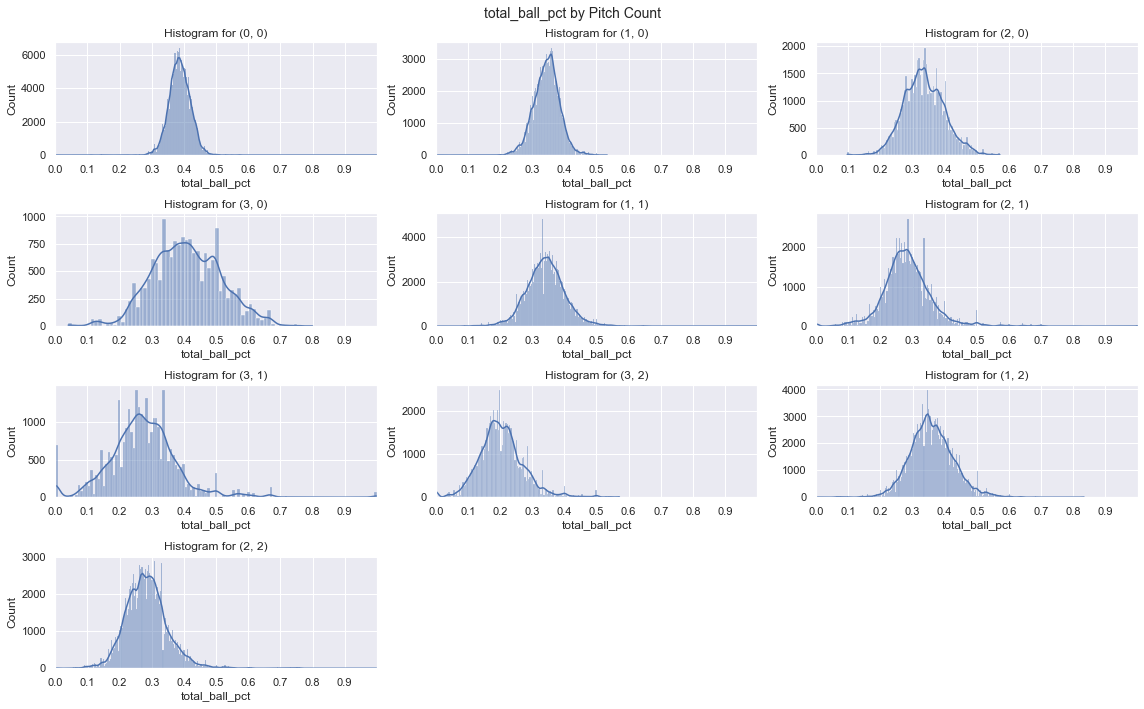

----------------------------------------------------------------------------------------------------


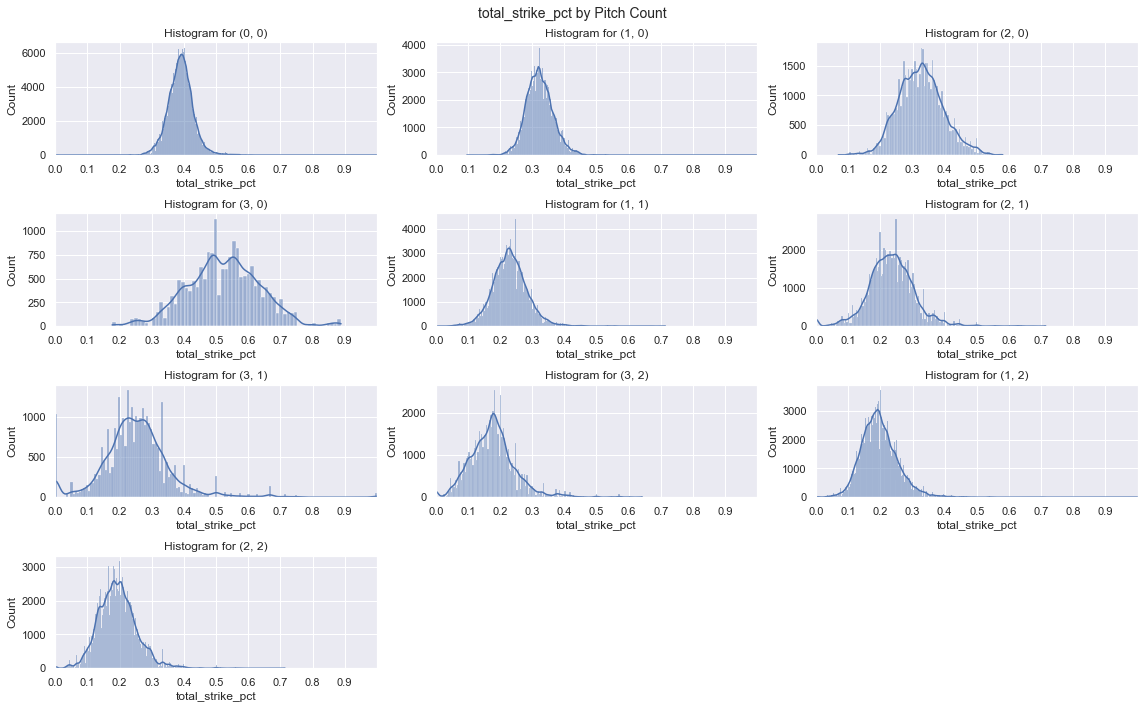

----------------------------------------------------------------------------------------------------


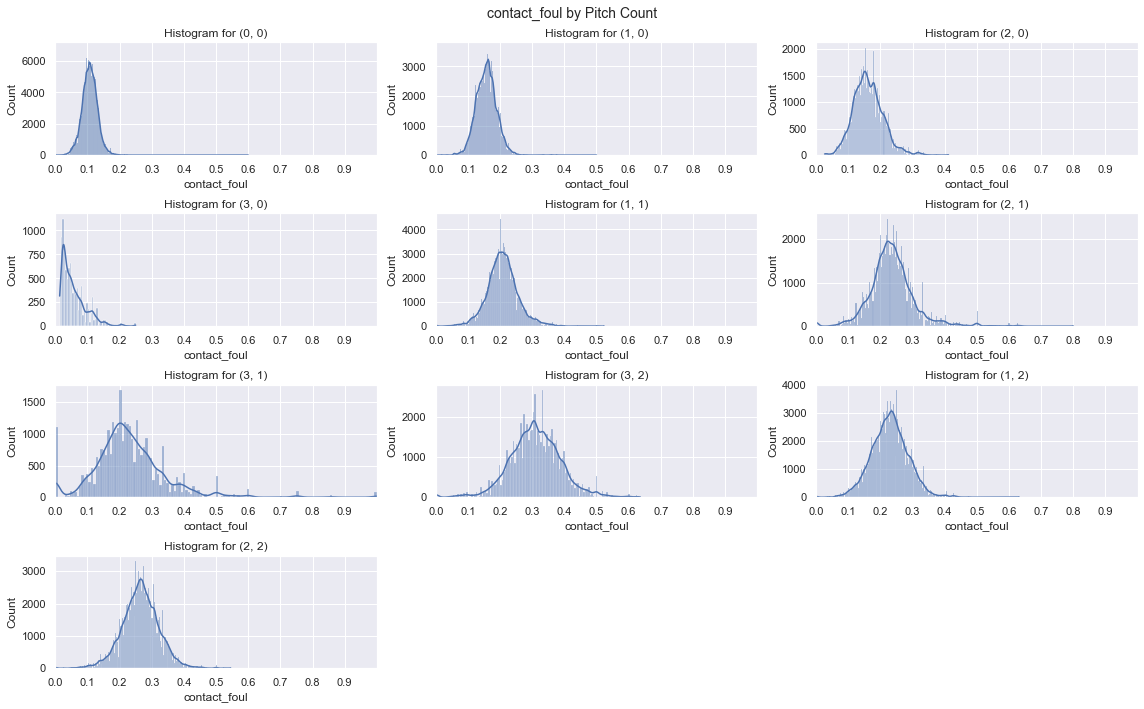

----------------------------------------------------------------------------------------------------


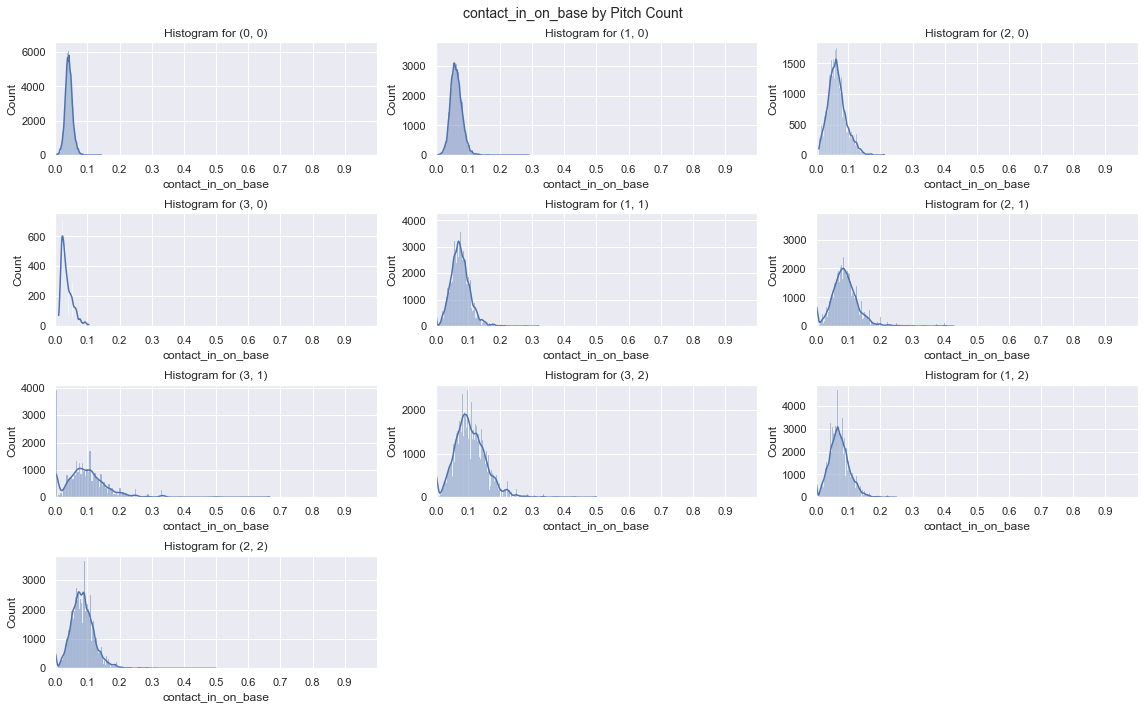

----------------------------------------------------------------------------------------------------


In [14]:
event_types = ['total_ball_pct', 'total_strike_pct', 'contact_foul', 'contact_in_on_base']
for event_type in event_types:
    compute_count_dists(event_type=event_type)

### Look at the accuacy for each moment (if I give a 30% chance of it happening - it should happen ~30% of the time )

In [15]:
# bin each forcast into .02 buckets for evaluation
bins = np.arange(0, 1, .0025)
binned_df = results_df
prob_cols = prob_cols + ['max_prob']

for c in prob_cols: 
    # create a placeholder columns
    binned_df[f'{c}_bin'] = None
    for i in range(len(bins)-1): 
        binned_df[f'{c}_bin'] = np.where(
            binned_df[c].between(bins[i], bins[i+1]), bins[i], binned_df[f'{c}_bin']
     )

In [16]:
def plot_accuracy(outcome): 
    outcome_df = binned_df.loc[binned_df['predicted_result'] == outcome]
    accuracy_df = (
        outcome_df.groupby(f'{outcome}_bin').agg(
            total_predicted=('correct_flag', 'sum'),
            total_occured=('correct_flag', 'count') 
    )).reset_index()
    
    accuracy_df['pct'] = accuracy_df['total_predicted'] / accuracy_df['total_occured']
    
    # take only the top 99 percent 
    
    x_vals, y_vals = accuracy_df['pct'].to_numpy(), accuracy_df[f'{outcome}_bin'].to_numpy()
    
    # fit a polynomial to the values
    _x_vals = np.linspace(x_vals[0], x_vals[-1], 500)
    coef = np.polyfit(x_vals, y_vals, 3)
    poly = np.poly1d(coef)
    _y_vals = poly(_x_vals)
    
    plt.figure(figsize=(16, 5))
    
    # plot the scatter points
    plt.scatter(x=x_vals, y=y_vals)
    
    # plot a perfect fit
    plt.axline((0, 0), slope=1, color='black', linestyle='--', transform=plt.gca().transAxes, label='Perfect Prediction Line')
    
    # plot the polynomial fit
    plt.plot(_x_vals, _y_vals, linestyle=':',label='Polynomal Fit', color='blue')
    
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xticks(np.arange(0, 1, .1))
    plt.yticks(np.arange(0, 1, .1))
    plt.ylabel('Predicted Probibility of Event Happening', fontsize=14)
    plt.xlabel('Percentage time Event Happening', fontsize=14)
    plt.title(f'Calibration Plot for {outcome.title()}', fontsize=16)
    plt.legend(loc='lower right')
    plt.show()
    return accuracy_df

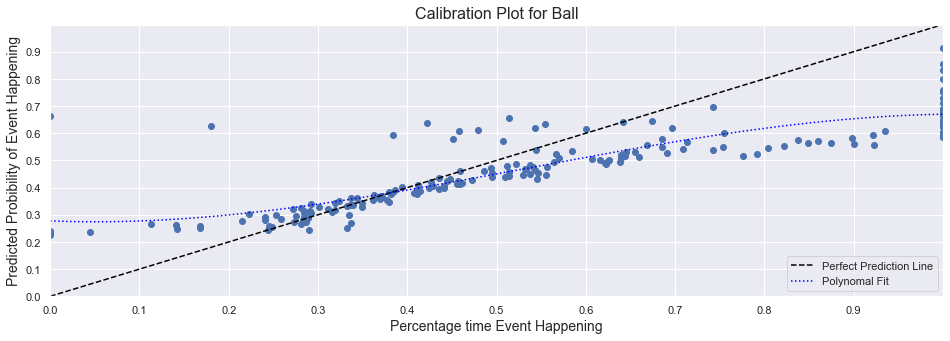

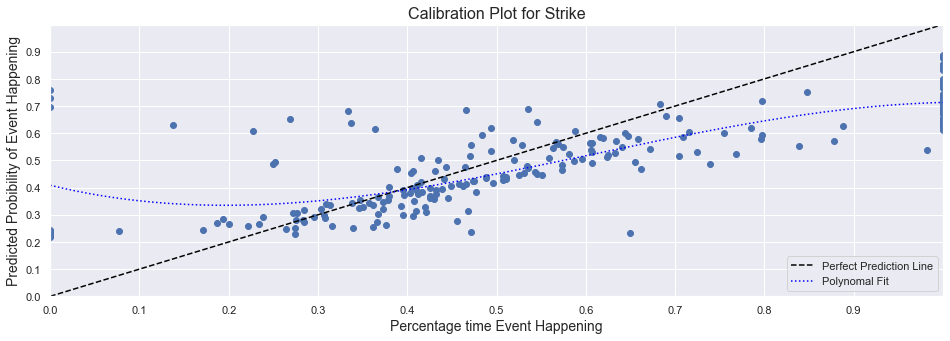

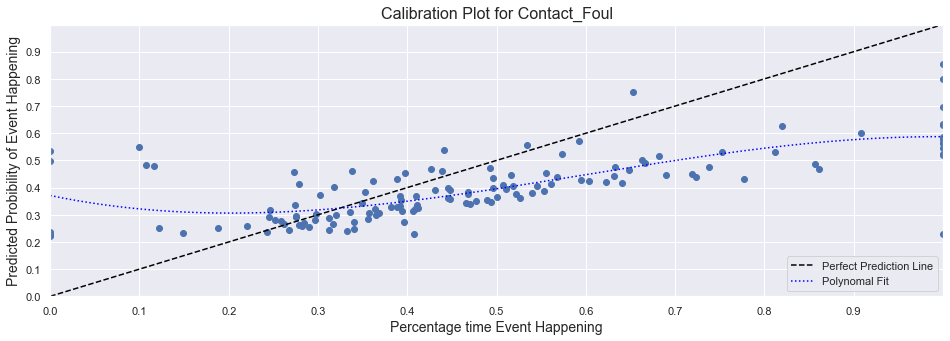

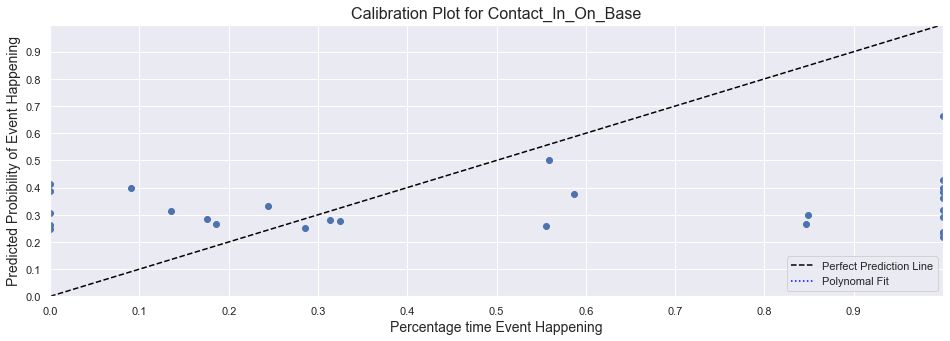

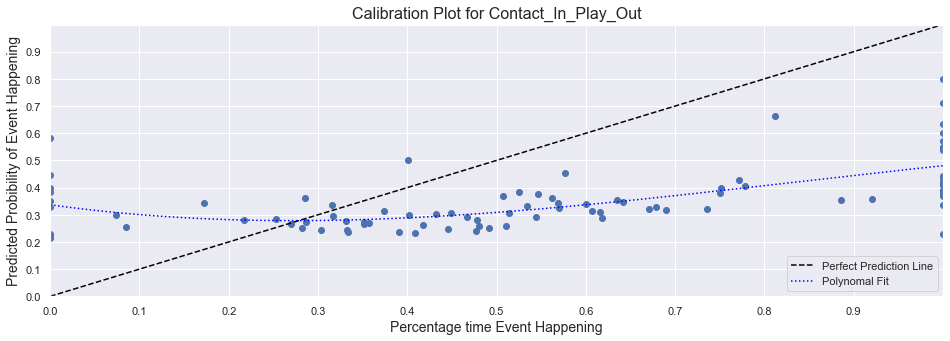

In [17]:
outcomes = ['ball', 'strike', 'contact_foul', 'contact_in_on_base', 'contact_in_play_out']
for outcome in outcomes: 
    plot_accuracy(outcome=outcome)